In [1]:
#imports
import pandas as pd
import itertools
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
import matplotlib.pyplot as plt
import numpy as np
import warnings
# Suppress warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('prostate_train.csv')
df_train.head()


,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564


In [3]:
df_test = pd.read_csv('prostate_test.csv')

features = ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']
output = ['lpsa']
X_train = df_train[features]
Y_train = df_train[output]
X_test = df_test[features]
Y_test = df_test[output]

X_train.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0


R squared:  0.5375164690552883


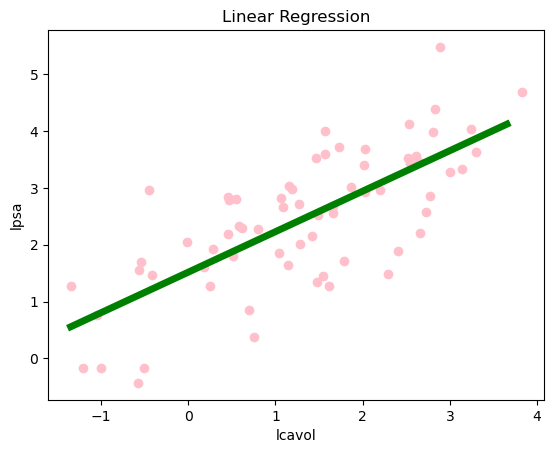

In [4]:
# training model on 'lcavol' feature
linear_reg = linear_model.LinearRegression()
linear_reg.fit(X_train['lcavol'].values.reshape(-1,1), Y_train)
r_squared = linear_reg.score(X_train['lcavol'].values.reshape(-1,1), Y_train)
print('R squared: ', r_squared)

# plot
x_axis = np.arange(X_train['lcavol'].min(), X_train['lcavol'].max(), 0.5)
y_axis = linear_reg.predict(x_axis.reshape(-1,1))
plt.scatter(X_train['lcavol'], Y_train, color='pink')
plt.plot(x_axis, y_axis, color='green', linewidth=5)
plt.xlabel('lcavol')
plt.ylabel('lpsa')
plt.title('Linear Regression')
plt.show()

In [5]:
# Returns a set of all subsets of size k
def findsubsets(S,k):
    return set(itertools.combinations(S, k))

In [6]:
# Best subset feature selection
from sklearn.model_selection import KFold

# Finds all possible subsets of 3 features 
subsets = findsubsets(features, 3)
highest_r_squared = -np.Inf
highest_features = []

# 5-fold cross validations 
for x in subsets:
    element = X_train[list(x)]
    cvs = cross_val_score(linear_model.LinearRegression(), element, Y_train, cv=5, scoring='r2')
    avg = cvs.mean()
    if avg > highest_r_squared:
        highest_r_squared = avg
        highest_features = x
        
# Finds the best performing set of features and corresponding R^2 value
print("Highest average r-squared: ", highest_r_squared)
print("Best performing set of features: ", highest_features)


Highest average r-squared:  -6.611191159159722
Best performing set of features:  ('lcavol', 'lweight', 'age')


Highest average r-squared:  -6.507279708487543
Best features:  ('lcavol', 'lweight')


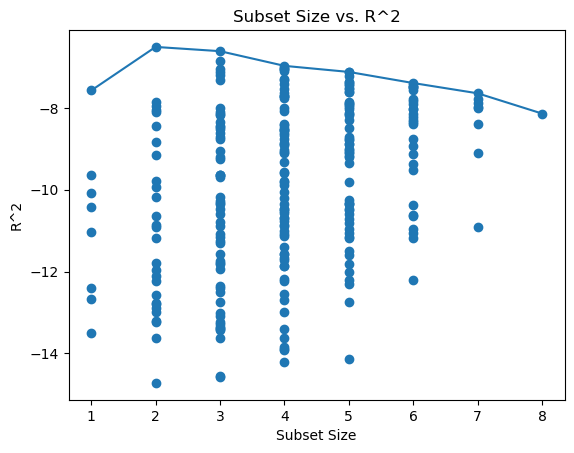

In [7]:
from sklearn.metrics import r2_score
scores = []
k_array = []
highest_avg = -np.Inf + np.zeros(len(features)+1)
highest_features = [[]]

# Finds all possible subsets of k features and evaluates a model on each set of features
# using 5-fold cross validation

for k in range(1,len(features)+1):
    highest_features.append([])
    subsets = list(findsubsets(features,k))
    
    for i in range(len(subsets)):
        element = X_train[list(subsets[i])]
        cvs = cross_val_score(linear_model.LinearRegression(), element, Y_train, cv=5, scoring='r2')
        avg = cvs.mean()
        scores.append(avg)
        k_array.append(k)
        if avg > highest_avg[k]:
            highest_avg[k] = avg
            highest_features[k] = subsets[i]

index = np.argmax(highest_avg)
top_features_final = highest_features[index]
print("Highest average r-squared: ", highest_avg[index])
print("Best features: ", top_features_final)

# Scatter plot shows every R^2 values for every run with subset size on the horizontal axis 
# and R^2 on the vertical axi s
plt.scatter(k_array, scores)
plt.plot(range(len(features)+1), highest_avg)
plt.title("Subset Size vs. R^2")
plt.xlabel("Subset Size")
plt.ylabel("R^2")
plt.show()

In [8]:
# Ridge Regression 

def printFeatureWeights(f, w):
  for idx in range(len(f)):
    print('%s : %f' % (f[idx], w[idx]))

features = ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']
l2 = linear_model.Ridge(alpha=0.5).fit(X_train, Y_train)
printFeatureWeights(features, l2.coef_[0])

lcavol : 0.576706
lweight : 0.593447
age : -0.018544
lbph : 0.145617
svi : 0.683643
lcp : -0.193621
gleason : -0.034175
pgg45 : 0.009508


Best Alpha:  6.25055192527397


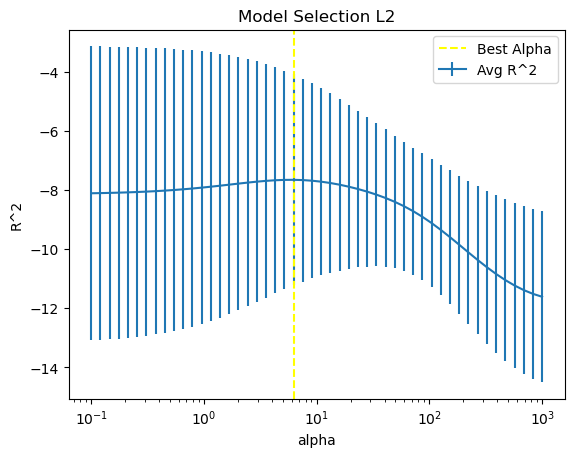

In [9]:
# created a range of 50 alpha values spaces logarithmically
alpha_arr = np.logspace(-1,3,num=50)
cv = 5
scores = np.zeros((len(alpha_arr), cv))
# 5-fold cross validation of Ridge regression for each alpha
# recording R^2 score for each run
for index in range(len(alpha_arr)):
    l2 = linear_model.Ridge(alpha=alpha_arr[index])
    scores[index,:] = cross_val_score(l2, X_train, Y_train, cv=cv, scoring='r2')
    
avg_r2 = np.mean(scores, axis=1)
std_r2 = np.std(scores, axis=1)
best_index = np.argmax(avg_r2)
best_alpha = alpha_arr[best_index]
print("Best Alpha: ", best_alpha)

# This plot shows the average R^2 with 1 SD error bars for each of the 50 alpha value
plt.errorbar(alpha_arr, avg_r2, yerr=std_r2, label='Avg R^2')
plt.axvline(best_alpha, linestyle='--', color="yellow", label="Best Alpha")
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel("R^2")
plt.title("Model Selection L2")
plt.legend()
plt.show()


In [20]:
# LASSO method

l1 = linear_model.Lasso(alpha=0.1).fit(X_train, Y_train)

# learned feature weights 
printFeatureWeights(features, l1.coef_)

lcavol : 0.538986
lweight : 0.184891
age : -0.006352
lbph : 0.128433
svi : 0.000000
lcp : -0.000000
gleason : -0.000000
pgg45 : 0.007727


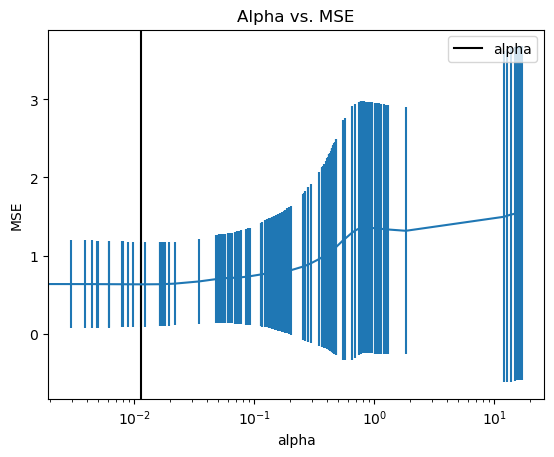

In [104]:
from sklearn.linear_model import LassoLarsCV, LassoCV

# finding good value for alpha and corresponding average mean squared error from using cross-validation 

cross_val = LassoLarsCV(cv=20, normalize=False).fit(X_train, Y_train)
alpha = cross_val.alpha_


plt.errorbar(cross_val.cv_alphas_, cross_val.mse_path_.mean(axis=1), yerr=cross_val.mse_path_.std(axis=1))
plt.axvline(alpha, color="black", label="alpha")
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Alpha vs. MSE')
plt.legend()
plt.show()

In [63]:
df_test = pd.read_csv('prostate_test.csv')
df_test.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,0.737164,3.473518,64,0.615186,0,-1.386294,6,0,0.765468
1,-0.776529,3.539509,47,-1.386294,0,-1.386294,6,0,1.047319
2,0.223144,3.244544,63,-1.386294,0,-1.386294,6,0,1.047319
3,1.205971,3.442019,57,-1.386294,0,-0.430783,7,5,1.398717
4,2.059239,3.501043,60,1.474763,0,1.348073,7,20,1.658228


In [62]:
X_test = df_test[['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']]
Y_test = df_test['lpsa']

In [78]:
from sklearn.metrics import mean_squared_error


# Using the best selected features to train the model and reporting mean squared error and R^2 
best_subsets = linear_model.LinearRegression()
best_subsets.fit(X_train[list(top_features_final)],Y_train)
predict =  best_subsets.predict(X_test[list(top_features_final)])

best_mse = mean_squared_error(Y_test,predict)
print('MSE: ', best_mse)

MSE:  0.49248234768050353


In [74]:
# training a Ridge Regression model using optimal regularization coefficient
best = linear_model.Ridge(alpha=best_alpha).fit(X_train, Y_train)
print('MSE: ', mean_squared_error(Y_test, best.predict(X_test)))

MSE:  0.5273494592770828


In [76]:
# training a LASSO Regression using optimal alpha params

predict = cross_val.predict(X_test)
mse = mean_squared_error(Y_test, lasso_predict)
print('MSE: ', mse)

MSE:  0.5077062843682018


In [102]:
# comparison

feature_weights_best_subset = list(best_subsets_best.coef_[0]) + ['null']*6 
test_errors_row = {'Features': 'Test Error', 'Best Subset': best_mse, 'Ridge': mean_squared_error(Y_test, best.predict(X_test)), 'LASSO' : mse}
results_df = pd.DataFrame({'Features' : features, 'Best Subset': feature_weights_best_subset, 'Ridge': best.coef_[0], 'LASSO' : cross_val.coef_})
results_df



,Features,Best Subset,Ridge,LASSO
0,lcavol,0.627607,0.550337,0.566300
1,lweight,0.738375,0.430148,0.572821
2,age,null,-0.014697,-0.017878
3,lbph,null,0.154290,0.141910
4,svi,null,0.387669,0.611769
5,lcp,null,-0.102993,-0.162829
6,gleason,null,-0.046865,0.000000
7,pgg45,null,0.009390,0.008575
